# Präsenzversuch zum Laval-Rotor

Name: Adrian Gabel <br/>
Datum: 04.02.2024 <br/>
Gruppe: 16 <br/>

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:<br/>
<br/>
-Was sagen kritische Drehzahlen aus und welche Auswirkung haben diese?

## Erster Versuch: Prüfstand #2
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="Rig_2.jpeg" width="500">

- Laval Rotor mit zwei Scheiben, die jeweils 500g wiegen.

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240119_153736_lavalrotor_16_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240119_153736_lavalrotor_16_02.h5"  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240119_153736_lavalrotor_16_02/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240119_153736_lavalrotor_16_02/1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240119_153736_lavalrotor_16_02/1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240119_153736_lavalrotor_16_02/1ee82398-0056-698f-8809-248cede81c54.json"
  },
  "1ee823d3-8511-6a0b-8cd5-972f083673c9": {
    "type": "sensor",
  

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)


In [5]:
#opening hdf5 file
path = path_measurement_folder+"/"+filename
f = h5py.File(path, "r")
import pprint
#creating lists
x = list(f.keys())
y = list(f.keys())
z = list(f.keys())
timestamp = list(f.keys())
rpm = list(f.keys())

#writing data to lists
for i,j in enumerate(f.keys()):
    x[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_x"])
    y[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_y"])
    z[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_z"])
    timestamp[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["timestamp"])
    rpm[i] = np.array(f[str(i)]["RawData"][uuid_motor_rpm]["motor_rpm"])

#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [6]:
importlib.reload(m_postprocessing)  # reload functions
#initializing list with correct length and calling vec_accel function in loop for every x entry
vec_accel = list(f.keys())
for i,j in enumerate(x):
    vec_accel[i] = m_postprocessing.get_vec_accel(x[i],y[i],z[i])
    
#initializing list with correct length and calling interpolation function in loop for every key in hdf5 file
y_interp = list(f.keys())
for i,j in enumerate(f.keys()):
    y_interp[i] = m_postprocessing.interpolation(timestamp[i],vec_accel[i], interpolation_points)
    
#initializing lists with correct length and calling fft function in loop for every key in hdf5 file    
amp = list(f.keys())
freq = list(f.keys())
for k,l in enumerate(f.keys()):
    amp[k], freq[k] = m_postprocessing.my_fft_scaled(y_interp[k],interpolation_points)    

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

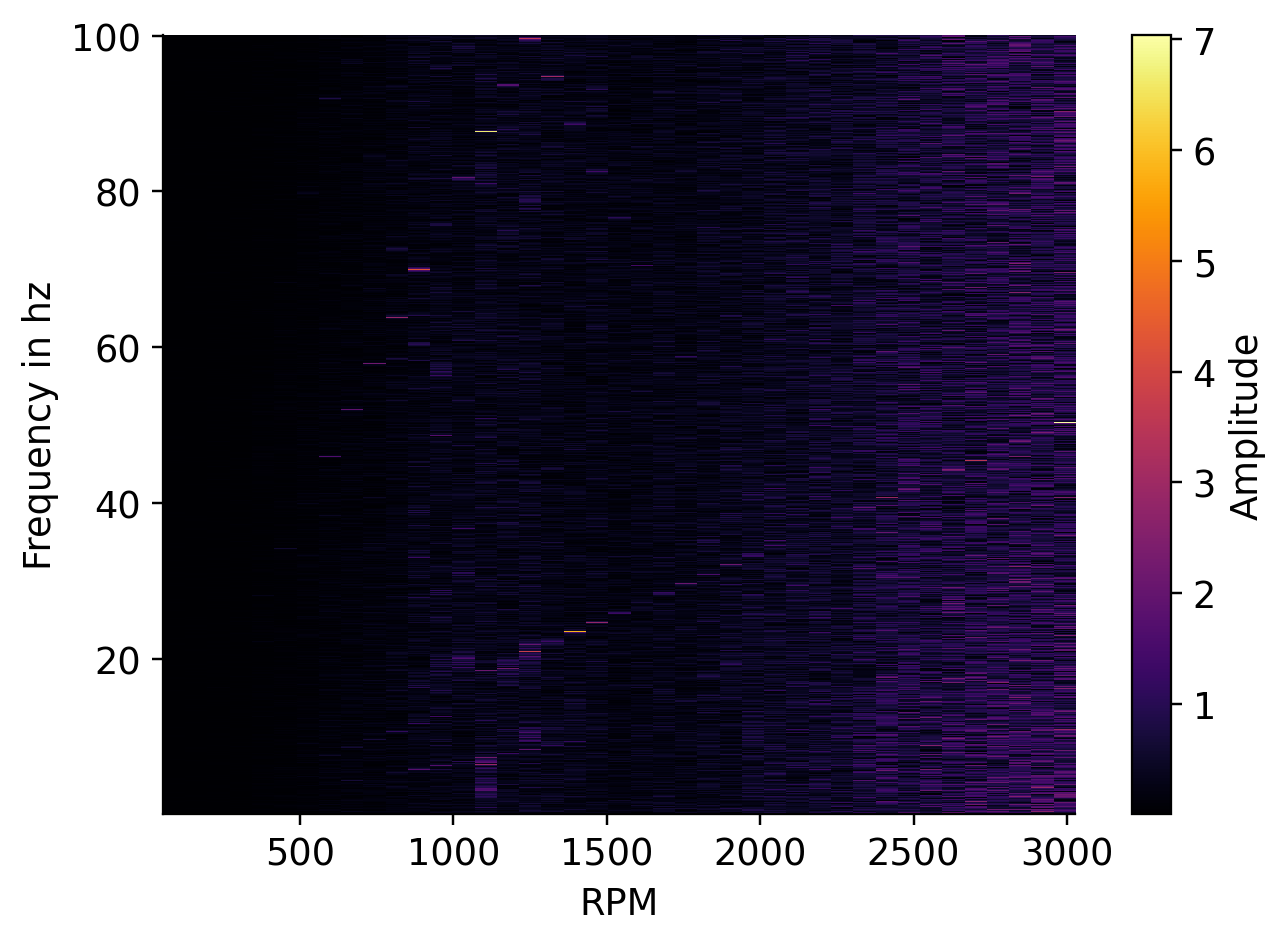

In [7]:
#writing fft amplitudes to matrix
amp_matrix = np.zeros((1000,len(list(f.keys()))))
for i,j in enumerate(f.keys()):
    amp_matrix[:,i] = amp[i]
#plot using imshow
plt.imshow(amp_matrix, aspect='auto', origin='lower', extent=(rpm[0], rpm[-1], min(freq[0]), max(freq[0])),cmap='inferno',interpolation="none")
plt.xlabel("RPM")
plt.ylabel("Frequency in hz")
colorbar = plt.colorbar()
colorbar.set_label("Amplitude")

## Zweiter Datensatz: Prüfstand #3

#### 1. Einlesen der Mess- und Metadaten

In [8]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_112539_lavalrotor_01_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_112539_lavalrotor_01_03.h5"  # name of the H5-file

In [9]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

In [10]:
#opening hdf5 file
path = path_measurement_folder+"/"+filename
f = h5py.File(path, "r")
import pprint
#creating lists
x = list(f.keys())
y = list(f.keys())
z = list(f.keys())
timestamp = list(f.keys())
rpm = list(f.keys())

#writing data to lists
for i,j in enumerate(f.keys()):
    x[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_x"])
    y[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_y"])
    z[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_z"])
    timestamp[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["timestamp"])
    rpm[i] = np.array(f[str(i)]["RawData"][uuid_motor_rpm]["motor_rpm"])

#### 2. Verarbeitung der Messdaten

In [11]:
importlib.reload(m_postprocessing)  # reload functions
#initializing list with correct length and calling vec_accel function in loop for every x entry
vec_accel = list(f.keys())
for i,j in enumerate(x):
    vec_accel[i] = m_postprocessing.get_vec_accel(x[i],y[i],z[i])
    
#initializing list with correct length and calling interpolation function in loop for every key in hdf5 file
y_interp = list(f.keys())
for i,j in enumerate(f.keys()):
    y_interp[i] = m_postprocessing.interpolation(timestamp[i],vec_accel[i], interpolation_points)
    
#initializing lists with correct length and calling fft function in loop for every key in hdf5 file    
amp = list(f.keys())
freq = list(f.keys())
for k,l in enumerate(f.keys()):
    amp[k], freq[k] = m_postprocessing.my_fft_scaled(y_interp[k],interpolation_points) 

#### 3. Darstellung mittels Campbell-Diagramm

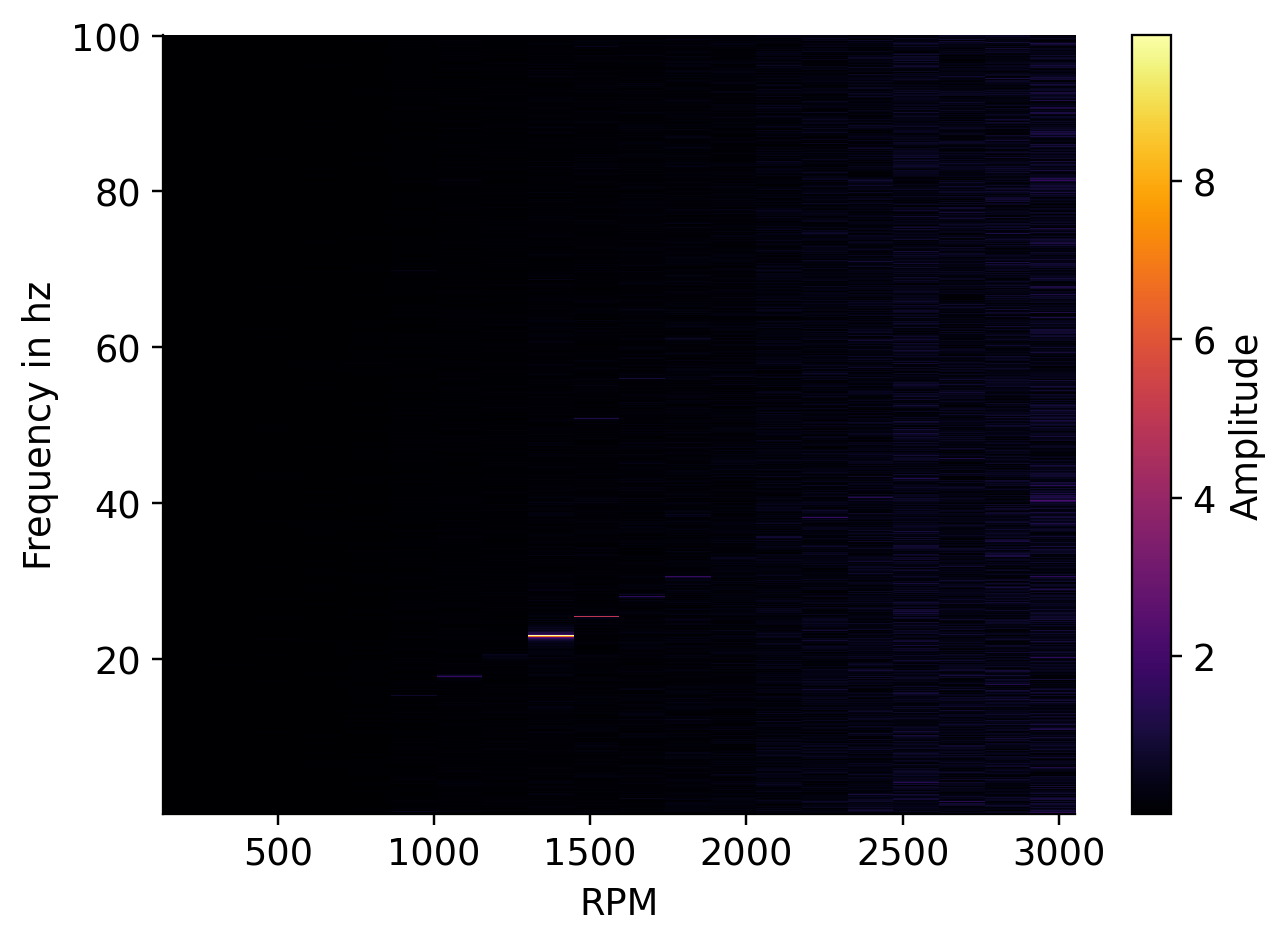

In [12]:
#writing fft amplitudes to matrix
amp_matrix = np.zeros((1000,len(list(f.keys()))))
for i,j in enumerate(f.keys()):
    amp_matrix[:,i] = amp[i]
#plot using imshow
plt.imshow(amp_matrix, aspect='auto', origin='lower', extent=(rpm[0], rpm[-1], min(freq[0]), max(freq[0])),cmap='inferno',interpolation="none")
plt.xlabel("RPM")
plt.ylabel("Frequency in hz")
colorbar = plt.colorbar()
colorbar.set_label("Amplitude")

## Dritter Datensatz: Prüfstand #4

#### 1. Einlesen der Mess- und Metadaten

In [13]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240109_104244_lavalrotor_01_04"
)  # path to the folder with H5-file and metadata
filename = "data_20240109_104244_lavalrotor_01_04.h5"  # name of the H5-file

In [14]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823ce-82b9-6d4e-a621-60af4e6f5cc1": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee823ce-82b9-6d4e-a621-60af4e6f5cc1.json"
  },
  "1ee823b6-50dc-6670-aea5-35f6dd717e83": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee823b6-50dc-6670-aea5-35f6dd717e83.json"
  },
  "1ee8239b-46ec-63dc-8aa4-b8751ac37fd3": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee8239b-46ec-63dc-8aa4-b8751ac37fd3.json"
  },
  "1ee823d6-3d20-6332-83f5-6876b760dcf3": {
    "type": "sensor",
  

In [15]:
#opening hdf5 file
path = path_measurement_folder+"/"+filename
f = h5py.File(path, "r")
import pprint
#creating lists
x = list(f.keys())
y = list(f.keys())
z = list(f.keys())
timestamp = list(f.keys())
rpm = list(f.keys())

#writing data to lists
for i,j in enumerate(f.keys()):
    x[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_x"])
    y[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_y"])
    z[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_z"])
    timestamp[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["timestamp"])
    rpm[i] = np.array(f[str(i)]["RawData"][uuid_motor_rpm]["motor_rpm"])

#### 2. Verarbeitung der Messdaten

In [16]:
importlib.reload(m_postprocessing)  # reload functions
#initializing list with correct length and calling vec_accel function in loop for every x entry
vec_accel = list(f.keys())
for i,j in enumerate(x):
    vec_accel[i] = m_postprocessing.get_vec_accel(x[i],y[i],z[i])
    
#initializing list with correct length and calling interpolation function in loop for every key in hdf5 file
y_interp = list(f.keys())
for i,j in enumerate(f.keys()):
    y_interp[i] = m_postprocessing.interpolation(timestamp[i],vec_accel[i], interpolation_points)
    
#initializing lists with correct length and calling fft function in loop for every key in hdf5 file    
amp = list(f.keys())
freq = list(f.keys())
for k,l in enumerate(f.keys()):
    amp[k], freq[k] = m_postprocessing.my_fft_scaled(y_interp[k],interpolation_points) 

#### 3. Darstellung mittels Campbell-Diagramm

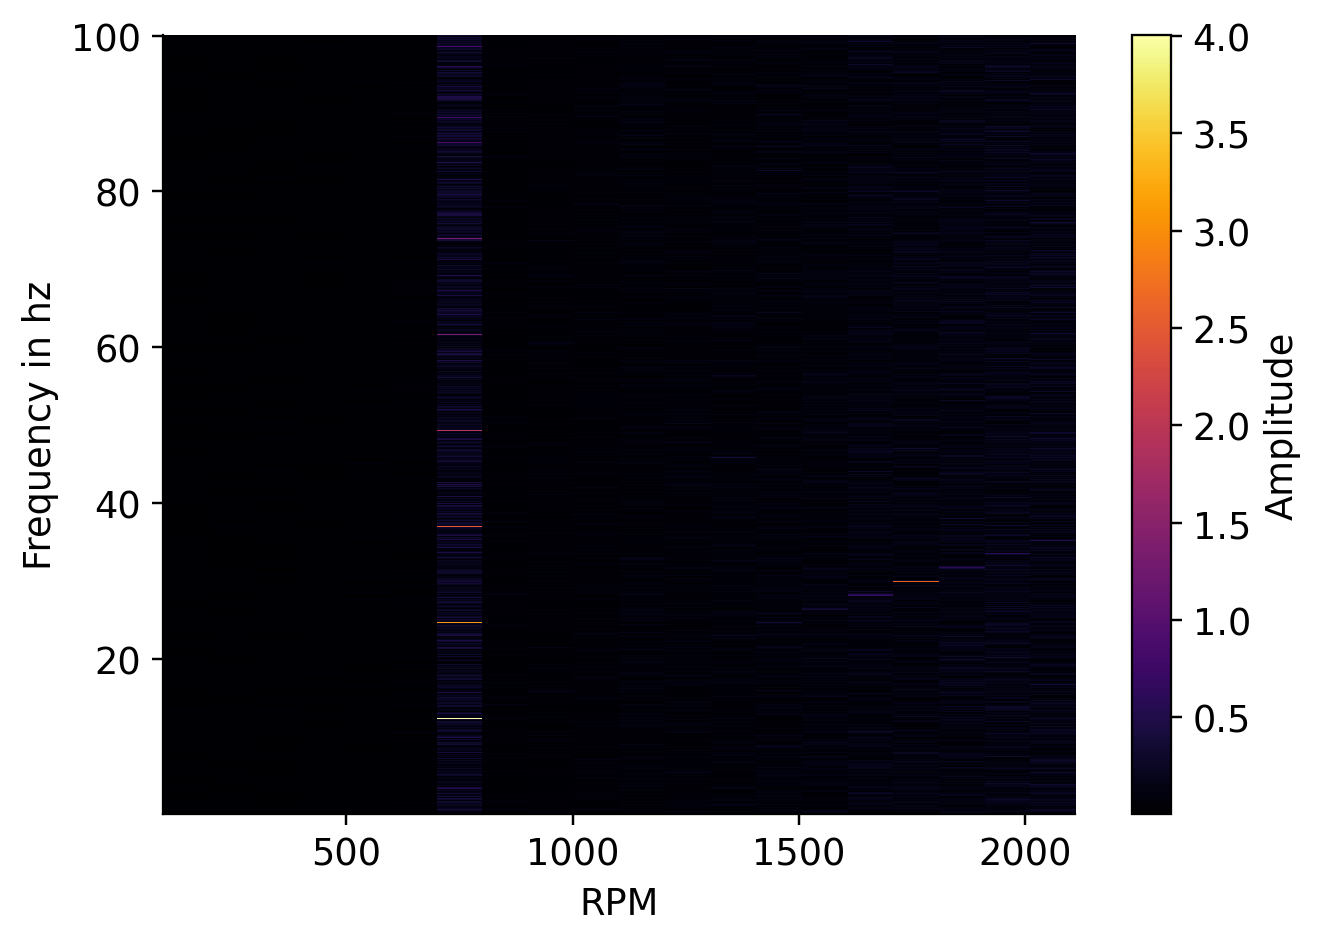

In [17]:
#writing fft amplitudes to matrix
amp_matrix = np.zeros((1000,len(list(f.keys()))))
for i,j in enumerate(f.keys()):
    amp_matrix[:,i] = amp[i]
#plot using imshow
plt.imshow(amp_matrix, aspect='auto', origin='lower', extent=(rpm[0], rpm[-1], min(freq[0]), max(freq[0])),cmap='inferno',interpolation="none")
plt.xlabel("RPM")
plt.ylabel("Frequency in hz")
colorbar = plt.colorbar()
colorbar.set_label("Amplitude")

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Kritische Drehzahlen sind bei der Beurteilung von rotierenden Bauteilen von großer Bedeutung. Sie zeigen uns, welche Bereiche beim Betrieb dieser Bauteile zu vermeiden sind, da diese dort am meisten Schwingungen erfahren. Kritische Drehzahlen sollten also möglichst zügig durchfahren werden, sodass nur sehr kurz Schwingungen auftreten.

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

Wir haben für den gegebenen Laval-Rotor mit 2 scheiben kritische Drehzahlen von 769 U/min und 2979 U/min berechnet. Die gemessene kritische Drehzahl bei 3000 U/min passt sehr gut, jedoch haben wir aufgrund von Messfehlern unter 800 U/min keine Aussagekräftigen Messwerte. Dies könnte z.B. aufgrund von Aliasing sein.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Das Experiment im Labor hat die kritischen Drehzahlen eines Laval-Rotors gut dargestellt. Es war sehr gut zu beobachten wie der Rotor sich in den Resonanzbereichen stark aufgeschaukelt hat und nach durchfahren der ersten kritischen Drehzahl wieder ruhiger lief.
Insgesamt hat mir der Versuch sehr gefallen. Ich habe einiges über Eigenfrequenzen gelernt und habe somit ein besseres Verständnis für diese.